explore data and prepare for model building

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data = train_data.dropna()

train_data = pd.get_dummies(train_data, columns=['parentspecies'])

scaler = StandardScaler()
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numeric_columns] = scaler.fit_transform(train_data[numeric_columns])

print(train_data.head())

         ID  log_pSat_Pa        MW  NumOfAtoms    NumOfC    NumOfO    NumOfN  \
0 -1.732855    -1.852422 -0.821253   -0.625586 -0.593455 -0.378290 -1.500663   
1 -1.732745     0.233035  0.912392    1.666040  1.464262  0.023877  1.314858   
2 -1.732636    -0.222260  2.080320    2.047978  2.150168  1.230377  1.314858   
3 -1.732526    -1.332871  0.689715    0.520227  0.092451  0.828210 -0.092903   
4 -1.732417     0.402894 -1.264607   -1.198493  0.092451 -1.182623 -1.500663   

   NumHBondDonors  NumOfConf  NumOfConfUsed  ...  hydroperoxide  \
0        1.762932   1.251126       0.969956  ...       1.763400   
1       -1.173103   0.026537       0.969956  ...       0.328098   
2       -1.173103   0.380635       0.969956  ...       0.328098   
3        1.762932   2.647846      -1.552772  ...       0.328098   
4       -1.173103  -0.755429       0.424501  ...       0.328098   

   carbonylperoxyacid  nitroester  parentspecies_apin  \
0           -0.557176   -0.113512               False   
1 

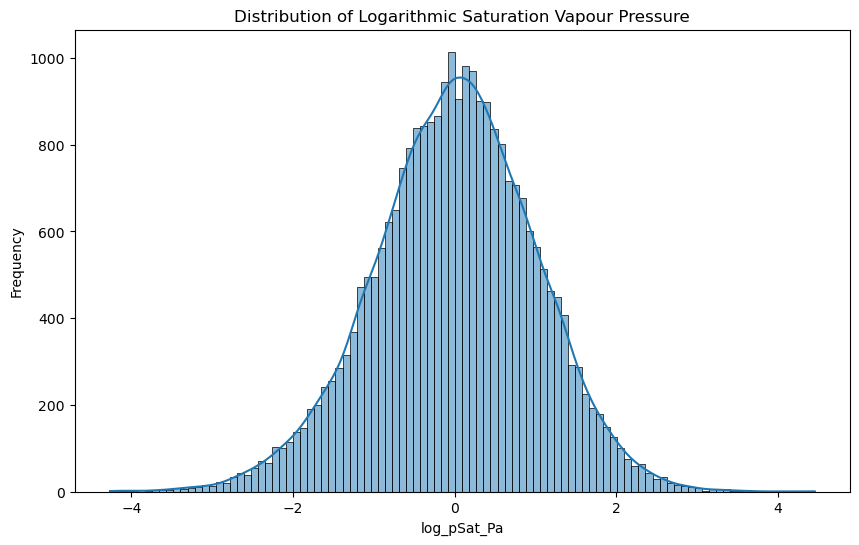

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train_data['log_pSat_Pa'], kde=True)
plt.title('Distribution of Logarithmic Saturation Vapour Pressure')
plt.xlabel('log_pSat_Pa')
plt.ylabel('Frequency')
plt.show()

log_pSat_Pa is the target variable we are trying to predict

distribution is highly skewed, we might consider using models that can handle skewed data or applying transformations

peak shows median

width is range

no outliers

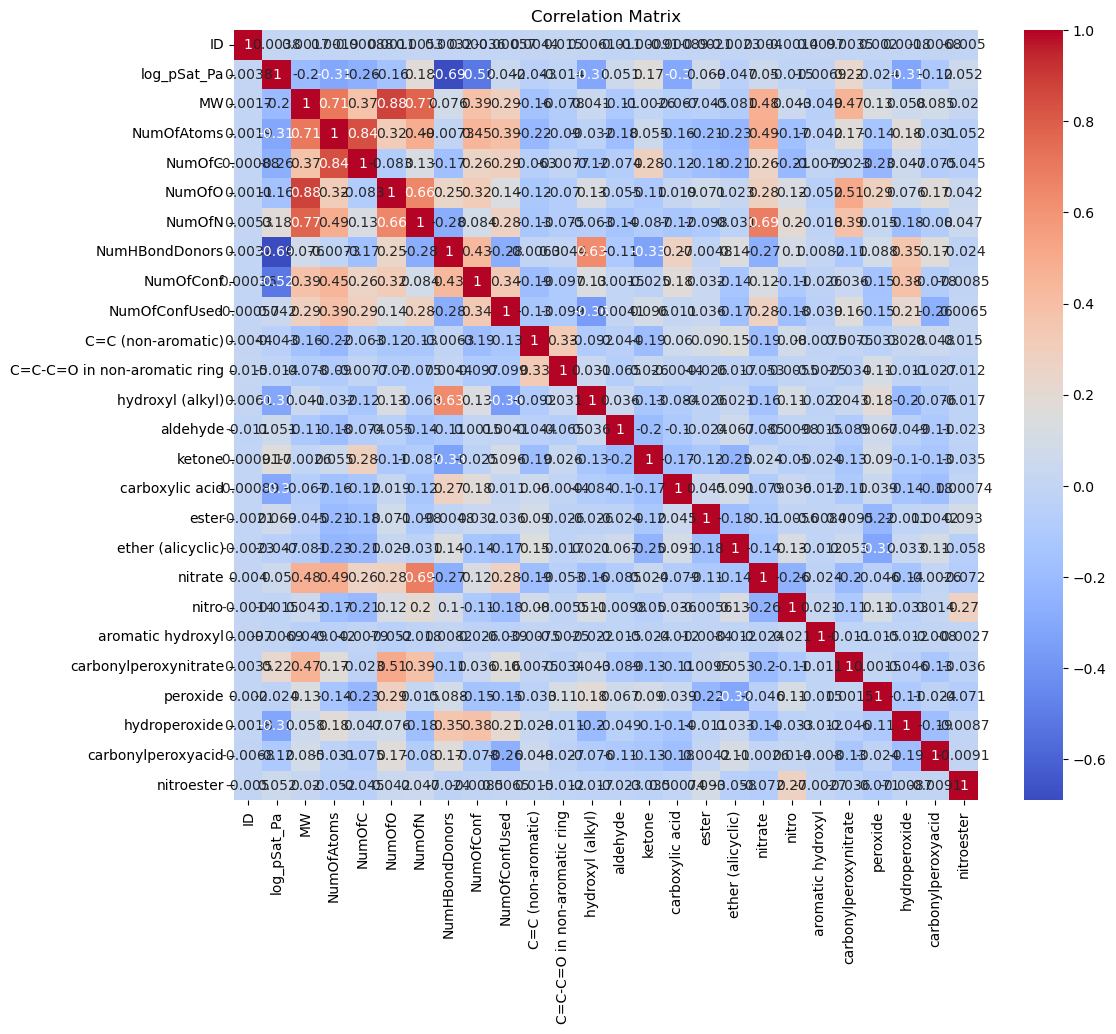

In [ ]:
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
correlation_matrix = train_data[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

High Positive Correlation: Indicates that as one feature increases, the other feature also increases.
High Negative Correlation: Indicates that as one feature increases, the other feature decreases.
Low or No Correlation: Indicates little to no linear relationship between the features.

identify linear relationships

Strong correlations (positive or negative) indicate that one feature can be predicted from another.

High correlations can show multicollinearity

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint as sp_randint

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

features = ['MW', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN', 'NumHBondDonors', 'NumOfConf', 'NumOfConfUsed', 'C=C (non-aromatic)', 'C=C-C=O in non-aromatic ring', 'hydroxyl (alkyl)', 'aldehyde', 'ketone', 'carboxylic acid', 'ester', 'ether (alicyclic)', 'nitrate', 'nitro', 'aromatic hydroxyl', 'carbonylperoxynitrate', 'peroxide', 'hydroperoxide', 'carbonylperoxyacid', 'nitroester']
categorical_features = ['parentspecies']
target = 'log_pSat_Pa'

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

X = train_df[features + categorical_features]
y = train_df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'regressor__n_estimators': sp_randint(50, 200),
    'regressor__max_depth': sp_randint(3, 10),
    'regressor__min_samples_split': sp_randint(2, 11),
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2]
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)
print(f'R2 Score: {r2_score(y_val, y_pred)}')
print(f'Mean Squared Error: {mean_squared_error(y_val, y_pred)}')

X_test = test_df[features + categorical_features]
test_predictions = best_model.predict(X_test)

submission = pd.DataFrame({
    'ID': test_df['ID'],
    'TARGET': test_predictions
})

submission['TARGET'] = submission['TARGET'].round(9)

submission.to_csv('submission.csv', index=False)

R2 Score: 0.743681247974149
Mean Squared Error: 2.499770373820834
